In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import warnings
warnings.filterwarnings('ignore')

# Physical parameters from the paper
R = 0.1           # Rotational parameter
xi = 10.0         # Gaussian separation parameter
m_vals = np.array([-1, 0, 1])  # Gaussian positions at -ξ, 0, +ξ

def hamiltonian(x, p, I, theta, V0):
    """
    Hamiltonian: H = p²/2 + RI²/2 + V cos(θ) Σ exp[-(x - mξ)²]
    """
    kinetic = 0.5 * p**2
    rotational = 0.5 * R * I**2
    
    potential_sum = np.sum([np.exp(-(x - m*xi)**2) for m in m_vals])
    potential = V0 * np.cos(theta) * potential_sum
    
    return kinetic + rotational + potential

def equations_of_motion(state, t, V0):
    """
    Classical equations of motion from Hamilton's equations:
    ẋ = ∂H/∂p, ṗ = -∂H/∂x, θ̇ = ∂H/∂I, İ = -∂H/∂θ
    """
    x, p, I, theta = state
    
    # ẋ = ∂H/∂p = p
    x_dot = p
    
    # ṗ = -∂H/∂x = -V cos(θ) Σ [-2(x - mξ)] exp[-(x - mξ)²]
    dV_dx = np.sum([-2*(x - m*xi) * np.exp(-(x - m*xi)**2) for m in m_vals])
    p_dot = -V0 * np.cos(theta) * dV_dx
    
    # θ̇ = ∂H/∂I = RI
    theta_dot = R * I
    
    # İ = -∂H/∂θ = V sin(θ) Σ exp[-(x - mξ)²]
    potential_sum = np.sum([np.exp(-(x - m*xi)**2) for m in m_vals])
    I_dot = V0 * np.sin(theta) * potential_sum
    
    return [x_dot, p_dot, I_dot, theta_dot]

print("Hamiltonian system setup complete")
print(f"System parameters: R = {R}, ξ = {xi}")


Hamiltonian system setup complete
System parameters: R = 0.1, ξ = 10.0


In [2]:
def variational_equations(state_and_tangent, t, V0):
    """
    Combined equations of motion and variational equations for Lyapunov calculation
    state_and_tangent = [x, p, I, θ, δx₁, δp₁, δI₁, δθ₁, δx₂, δp₂, δI₂, δθ₂, ...]
    """
    # Extract state variables
    x, p, I, theta = state_and_tangent[:4]
    
    # Get equations of motion
    state_dot = equations_of_motion([x, p, I, theta], t, V0)
    
    # Calculate Jacobian matrix elements for linearization
    # ∂²H/∂x² terms
    d2V_dx2 = np.sum([
        (4*(x - m*xi)**2 - 2) * np.exp(-(x - m*xi)**2) for m in m_vals
    ])
    
    # ∂²H/∂x∂θ terms  
    dV_dx = np.sum([-2*(x - m*xi) * np.exp(-(x - m*xi)**2) for m in m_vals])
    
    # ∂²H/∂θ∂x terms
    d2V_dtheta_dx = -V0 * np.sin(theta) * dV_dx
    
    # ∂²H/∂θ² terms
    potential_sum = np.sum([np.exp(-(x - m*xi)**2) for m in m_vals])
    d2V_dtheta2 = -V0 * np.cos(theta) * potential_sum
    
    # Jacobian matrix of the flow
    jacobian = np.array([
        [0,    1,    0,     0],                    # ∂ẋ/∂(x,p,I,θ)
        [V0 * np.cos(theta) * -(d2V_dx2), 0, 0, V0 * np.sin(theta) * dV_dx],  # ∂ṗ/∂(x,p,I,θ)                               
        [V0 * np.sin(theta) * dV_dx, 0, 0, V0 * np.cos(theta) * potential_sum], # ∂İ/∂(x,p,I,θ)
        [0,    0,    R,     0]      # ∂θ̇/∂(x,p,I,θ)                            
    ])
    
    # Apply variational equations to tangent vectors
    tangent_dots = []
    n_tangent_vectors = (len(state_and_tangent) - 4) // 4
    
    for i in range(n_tangent_vectors):
        start_idx = 4 + i*4
        tangent_vector = state_and_tangent[start_idx:start_idx+4]
        tangent_dot = jacobian @ tangent_vector
        tangent_dots.extend(tangent_dot)
    
    return state_dot + tangent_dots

def gram_schmidt(vectors):
    """Gram-Schmidt orthogonalization for numerical stability"""
    orthogonal_vectors = []
    for v in vectors:
        for u in orthogonal_vectors:
            v = v - np.dot(v, u) * u
        norm = np.linalg.norm(v)
        if norm > 1e-12:
            orthogonal_vectors.append(v / norm)
    return orthogonal_vectors

print("Variational equations defined")


Variational equations defined


In [3]:
def calculate_lyapunov_exponents(initial_state, V0, total_time=500, dt=0.1, n_lyap=4):
    """
    Calculate Lyapunov exponents using variational method
    """
    # Time array
    t = np.arange(0, total_time, dt)
    
    # Initialize: state + identity matrix as tangent vectors
    initial_tangent = np.eye(4).flatten()
    initial_full = np.concatenate([initial_state, initial_tangent])
    
    # Storage for Lyapunov sums
    lyap_sums = np.zeros(n_lyap)
    
    # Integration parameters
    chunk_size = int(10 / dt)  # Reorthogonalize every 10 time units
    n_chunks = len(t) // chunk_size
    
    current_state = initial_full.copy()
    
    for chunk in range(n_chunks):
        # Integrate one chunk
        t_chunk = t[chunk*chunk_size:(chunk+1)*chunk_size + 1]
        
        if len(t_chunk) < 2:
            break
            
        try:
            solution = odeint(variational_equations, current_state, t_chunk, args=(V0,))
            final_state = solution[-1]
        except:
            print(f"Integration failed at chunk {chunk}")
            break
        
        # Extract tangent vectors
        tangent_vectors = []
        for i in range(n_lyap):
            start_idx = 4 + i*4
            tangent_vectors.append(final_state[start_idx:start_idx+4])
        
        # QR decomposition for orthogonalization and norm extraction
        Q, R = np.linalg.qr(np.column_stack(tangent_vectors))
        
        # Accumulate logarithms of diagonal elements
        for i in range(min(n_lyap, R.shape[0])):
            if R[i,i] > 0:
                lyap_sums[i] += np.log(abs(R[i,i]))
        
        # Prepare for next chunk
        orthogonal_tangents = Q.T.flatten()
        current_state = np.concatenate([final_state[:4], orthogonal_tangents])
    
    # Calculate average Lyapunov exponents
    total_time_used = n_chunks * chunk_size * dt
    lyap_exponents = lyap_sums / total_time_used
    
    return lyap_exponents, total_time_used

# Test with a single V0 value
test_V0 = 1.0
initial_state = [0.1, 0.1, 0.1, 0.1]  # Small initial conditions

print("Testing Lyapunov calculation...")
lyap_test, time_test = calculate_lyapunov_exponents(initial_state, test_V0, total_time=100)
print(f"Test V0 = {test_V0}: Lyapunov exponents = {lyap_test}")
print(f"Largest Lyapunov exponent: {lyap_test[0]:.6f}")



Testing Lyapunov calculation...
Test V0 = 1.0: Lyapunov exponents = [ 0.03513351  0.0171823  -0.02962396 -0.02992098]
Largest Lyapunov exponent: 0.035134


In [6]:
def explore_chaos_regime(V0_range, energy_range, n_trajectories=5):
    """
    Explore chaotic vs regular regimes by scanning V0 parameter space
    """
    results = {
        'V0_values': [],
        'max_lyapunov': [],
        'classification': [],
        'energy_values': []
    }
    
    print(f"Exploring {len(V0_range)} V0 values with {n_trajectories} trajectories each...")
    
    for i, V0 in enumerate(V0_range):
        print(f"Processing V0 = {V0:.2f} ({i+1}/{len(V0_range)})")
        
        lyap_values = []
        
        # Average over multiple initial conditions and energies
        for energy in energy_range:
            for traj in range(n_trajectories):
                # Generate initial conditions with specified energy
                # For simplicity, use random initial conditions
                x0 = np.random.uniform(-5, 5)
                theta0 = np.random.uniform(0, 2*np.pi)
                I0 = np.random.uniform(-2, 2)
                # I0 = 3.13
                # x0 = -12
                # theta0 = np.random.uniform(0, 2*np.pi)
                
                # Set momentum to satisfy energy constraint approximately
                potential_sum = np.sum([np.exp(-(x0 - m*xi)**2) for m in m_vals])
                potential_energy = 0.5 * R * I0**2 + V0 * np.cos(theta0) * potential_sum
                kinetic_target = max(0.1, energy - potential_energy)
                p0 = np.sqrt(2 * kinetic_target) * np.random.choice([-1, 1])
                
                initial_state = [x0, p0, I0, theta0]
                
                try:
                    lyap_exp, _ = calculate_lyapunov_exponents(
                        initial_state, V0, total_time=200, dt=0.05
                    )
                    lyap_values.append(lyap_exp[0])  # Largest Lyapunov exponent
                except:
                    continue
        
        if lyap_values:
            avg_lyap = np.mean(lyap_values)
            std_lyap = np.std(lyap_values)
            
            # Classification threshold
            chaos_threshold = 0.01  # Positive Lyapunov indicates chaos
            
            if avg_lyap > chaos_threshold:
                classification = 'Chaotic'
            elif avg_lyap < -chaos_threshold:
                classification = 'Regular'
            else:
                classification = 'Marginal'
            
            results['V0_values'].append(V0)
            results['max_lyapunov'].append(avg_lyap)
            results['classification'].append(classification)
            
            print(f"  V0 = {V0:.2f}: λ_max = {avg_lyap:.6f} ± {std_lyap:.6f} ({classification})")
    
    return results

# Define parameter ranges
V0_range = np.linspace(0.1, 4.0, 20)  # From weak to strong coupling
energy_range = [1.8, 2.0, 2.2]       # Multiple energy values

# Run the exploration
chaos_results = explore_chaos_regime(V0_range, energy_range, n_trajectories=3)         


Exploring 20 V0 values with 3 trajectories each...
Processing V0 = 0.10 (1/20)
  V0 = 0.10: λ_max = 0.000207 ± 0.004883 (Marginal)
Processing V0 = 0.31 (2/20)
  V0 = 0.31: λ_max = 0.004604 ± 0.005761 (Marginal)
Processing V0 = 0.51 (3/20)
  V0 = 0.51: λ_max = 0.002795 ± 0.003838 (Marginal)
Processing V0 = 0.72 (4/20)
  V0 = 0.72: λ_max = 0.004317 ± 0.007625 (Marginal)
Processing V0 = 0.92 (5/20)
  V0 = 0.92: λ_max = 0.007211 ± 0.007404 (Marginal)
Processing V0 = 1.13 (6/20)
  V0 = 1.13: λ_max = 0.008624 ± 0.006075 (Marginal)
Processing V0 = 1.33 (7/20)
  V0 = 1.33: λ_max = 0.002135 ± 0.002655 (Marginal)
Processing V0 = 1.54 (8/20)
  V0 = 1.54: λ_max = 0.004839 ± 0.003887 (Marginal)
Processing V0 = 1.74 (9/20)
  V0 = 1.74: λ_max = 0.007286 ± 0.006507 (Marginal)
Processing V0 = 1.95 (10/20)
  V0 = 1.95: λ_max = 0.007932 ± 0.005308 (Marginal)
Processing V0 = 2.15 (11/20)
  V0 = 2.15: λ_max = 0.009499 ± 0.006016 (Marginal)
Processing V0 = 2.36 (12/20)
  V0 = 2.36: λ_max = 0.010112 ± 0.0074

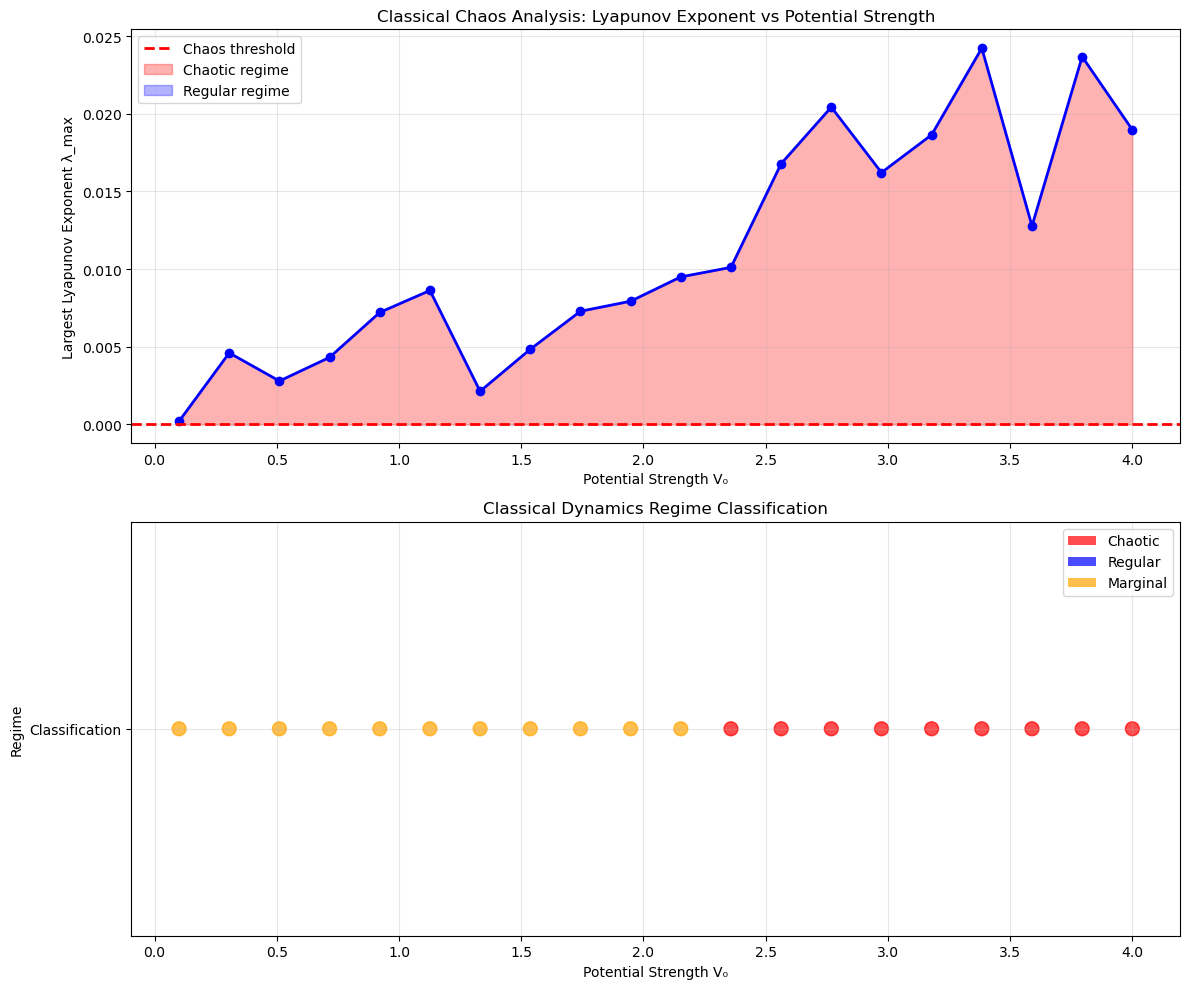


CLASSICAL CHAOS ANALYSIS SUMMARY
Total V₀ values analyzed: 20
Chaotic regimes: 9 (45.0%)
Regular regimes: 0 (0.0%)
Marginal regimes: 11 (55.0%)

Chaos-Regular Transition Points (V₀ values):

Comparison with Literature:
Paper irregular case: V₀ = 3.0 (should be chaotic)
Paper regular case: V₀ = 0.3 (should be regular)
Our result at V₀ ≈ 0.3: λ_max = 0.004604 (Marginal)


In [7]:
# Convert results to arrays for analysis
V0_vals = np.array(chaos_results['V0_values'])
lyap_vals = np.array(chaos_results['max_lyapunov'])
classifications = chaos_results['classification']

# Create visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot 1: Lyapunov exponent vs V0
ax1.plot(V0_vals, lyap_vals, 'bo-', linewidth=2, markersize=6)
ax1.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Chaos threshold')
ax1.fill_between(V0_vals, lyap_vals, 0, where=(lyap_vals > 0), 
                alpha=0.3, color='red', label='Chaotic regime')
ax1.fill_between(V0_vals, lyap_vals, 0, where=(lyap_vals <= 0), 
                alpha=0.3, color='blue', label='Regular regime')

ax1.set_xlabel('Potential Strength V₀')
ax1.set_ylabel('Largest Lyapunov Exponent λ_max')
ax1.set_title('Classical Chaos Analysis: Lyapunov Exponent vs Potential Strength')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: Regime classification
regime_colors = {'Chaotic': 'red', 'Regular': 'blue', 'Marginal': 'orange'}
colors = [regime_colors[cls] for cls in classifications]

ax2.scatter(V0_vals, [1]*len(V0_vals), c=colors, s=100, alpha=0.7)
ax2.set_xlabel('Potential Strength V₀')
ax2.set_ylabel('Regime')
ax2.set_title('Classical Dynamics Regime Classification')
ax2.set_ylim(0.5, 1.5)
ax2.set_yticks([1])
ax2.set_yticklabels(['Classification'])
ax2.grid(True, alpha=0.3)

# Add legend for regime colors
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='red', alpha=0.7, label='Chaotic'),
                  Patch(facecolor='blue', alpha=0.7, label='Regular'),
                  Patch(facecolor='orange', alpha=0.7, label='Marginal')]
ax2.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\n{'='*60}")
print(f"CLASSICAL CHAOS ANALYSIS SUMMARY")
print(f"{'='*60}")

chaotic_count = sum(1 for cls in classifications if cls == 'Chaotic')
regular_count = sum(1 for cls in classifications if cls == 'Regular')
marginal_count = sum(1 for cls in classifications if cls == 'Marginal')

print(f"Total V₀ values analyzed: {len(V0_vals)}")
print(f"Chaotic regimes: {chaotic_count} ({100*chaotic_count/len(classifications):.1f}%)")
print(f"Regular regimes: {regular_count} ({100*regular_count/len(classifications):.1f}%)")
print(f"Marginal regimes: {marginal_count} ({100*marginal_count/len(classifications):.1f}%)")

# Find transition points
if len(lyap_vals) > 1:
    # Find where Lyapunov exponent changes sign
    sign_changes = []
    for i in range(len(lyap_vals)-1):
        if lyap_vals[i] * lyap_vals[i+1] < 0:
            # Linear interpolation to find crossing point
            V0_cross = V0_vals[i] + (V0_vals[i+1] - V0_vals[i]) * (-lyap_vals[i]) / (lyap_vals[i+1] - lyap_vals[i])
            sign_changes.append(V0_cross)
    
    print(f"\nChaos-Regular Transition Points (V₀ values):")
    for i, V0_trans in enumerate(sign_changes):
        print(f"  Transition {i+1}: V₀ ≈ {V0_trans:.3f}")

# Compare with paper values
print(f"\nComparison with Literature:")
print(f"Paper irregular case: V₀ = 3.0 (should be chaotic)")
print(f"Paper regular case: V₀ = 0.3 (should be regular)")

if 3.0 in V0_vals:
    idx_3 = np.argmin(np.abs(V0_vals - 3.0))
    print(f"Our result at V₀ ≈ 3.0: λ_max = {lyap_vals[idx_3]:.6f} ({classifications[idx_3]})")

if any(abs(v - 0.3) < 0.1 for v in V0_vals):
    idx_03 = np.argmin(np.abs(V0_vals - 0.3))
    print(f"Our result at V₀ ≈ 0.3: λ_max = {lyap_vals[idx_03]:.6f} ({classifications[idx_03]})")
